In [35]:
# --- 1. Imports & Constants

import numpy as np
import matplotlib.pyplot as plt

# Physical constants
c     = 0.3          # m/ns
n_ref = 1.33         # refractive index of water

# Simulation knobs
I_0 = 3 * 1e7            # arbitrary initial intensity scale factor
L_max     = 2000.0   # m, max muon travel
L_att     = 100.0     # m, attenuation length
I_thresh  = 0.01     # relative intensity cutoff

# --- Muon Track in 3D ---
# Start point (x, y, z)
x0 = np.array([-600.0, 0.0, 0.0])

# Direction parameterized by spherical coordinates (zenith, azimuth)
muon_zenith_deg = 120.0
muon_azimuth_deg = 45.0
theta_dir = np.deg2rad(muon_zenith_deg)
phi_dir = np.deg2rad(muon_azimuth_deg)

# 3D unit direction vector u = (ux, uy, uz)
u = np.array([
    np.sin(theta_dir) * np.cos(phi_dir),
    np.sin(theta_dir) * np.sin(phi_dir),
    np.cos(theta_dir)
])

# --- Derived Cherenkov Quantities ---
β      = 1.0  # Assuming relativistic muon
theta_C = np.arccos(1 / (n_ref * β))
sin_C = np.sin(theta_C)
tan_C = np.tan(theta_C)


In [36]:
# Build DOM positions
n_dom_x = n_dom_y = n_dom_z = 10
spacing = 75.0
xs = (np.arange(n_dom_x) - (n_dom_x - 1) / 2) * spacing
ys = (np.arange(n_dom_y) - (n_dom_y - 1) / 2) * spacing
zs = (np.arange(n_dom_z) - (n_dom_z - 1) / 2) * spacing
DOM_positions = np.stack(np.meshgrid(xs, ys, zs), axis=-1).reshape(-1, 3)


In [37]:
def perp_distance(x0, u, x_dom):
    v = x_dom - x0
    proj = np.dot(v, u)*u
    return np.linalg.norm(v - proj)

def intensity(r_perp, L_att=L_att, sC=sin_C, I0=I_0, d_floor=5.0):
    """
    Physically: I ∝ exp(-d/L_att) / d^2, where d = r_perp / sinC.
    Numerically: clamp d with a floor to avoid gigantic sizes.
    """
    d = r_perp / sC
    d_eff = max(d, d_floor)           # <- clamp near-field
    I = I0 * np.exp(-d / L_att) / (d_eff**2)
    return I

def arrival_time(s0, r_perp, c=c, n=n_ref, sinC=sin_C, tanC=tan_C):
    
    # Time for muon to reach the point of closest approach (s0)
    t_mu_ca = s0 / c
    
    # Distance along track from closest approach to the emission point
    d_along_track = r_perp / tanC
    
    # Time for muon to travel this extra distance
    t_mu_extra = d_along_track / c

    # Time for photon to travel from emission point to DOM
    d_photon = r_perp / sinC
    t_ph = n * d_photon / c
    
    return (t_mu_ca - t_mu_extra) + t_ph



In [38]:
hits = []
for idx, x_dom in enumerate(DOM_positions):
    v = x_dom - x0
    s0 = np.dot(v, u)                    # path‐parameter of closest approach
    if not (0 <= s0 <= L_max):
        continue

    r_perp = perp_distance(x0, u, x_dom)
    d_along_track = r_perp / tan_C
    s_emit = s0 - d_along_track # Position of emission along the track
    if not (0 <= s_emit <= L_max):
        continue
    I = intensity(r_perp)
    if I < I_thresh:
        continue

    t = arrival_time(s0, r_perp) + np.random.normal(0, 2.5)  # add some jitter
    hits.append((idx, t, I))


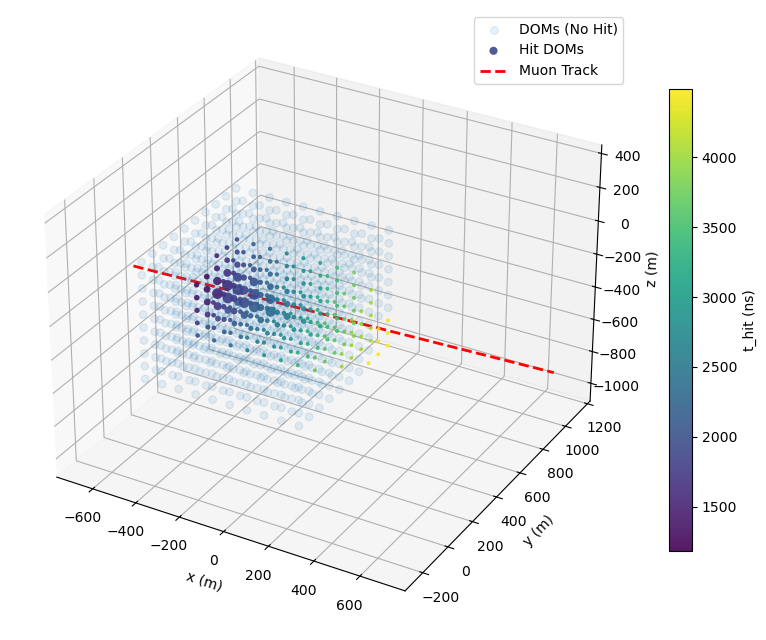

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# --- 3D Visualization ---

# Check if there are any hits to plot
if not hits:
    print("No hits were recorded. Cannot generate plot.")
else:
    # Unpack hits (this part is already 3D-compatible)
    idxs, times, ints = zip(*hits)
    hit_pts = DOM_positions[list(idxs)]

    # Compute non-hit DOMs
    all_idxs = np.arange(len(DOM_positions))
    non_hit_idxs = np.setdiff1d(all_idxs, list(idxs))
    non_pts = DOM_positions[non_hit_idxs]

    # Prepare the muon track line for plotting
    track_line = np.vstack((x0, x0 + L_max * u))

    # --- Create a 3D Plot ---
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    # --- Robust size mapping for plotting only (no physics change) ---
    ints = np.array(ints, dtype=float)

    # Handle inf/NaN safely (for plotting only)
    finite = np.isfinite(ints)
    if not finite.all():
        # set non-finite to a high but finite value so they get clipped
        ints[~finite] = np.nanmax(ints[finite]) if finite.any() else 0.0

    # Clip extreme values so a few huge hits don't dominate the scene
    hi = np.nanpercentile(ints, 98.0) if np.isfinite(ints).any() else 1.0
    ints_clipped = np.clip(ints, 0.0, hi)

    # Smooth dynamic range: size ∝ sqrt(intensity)
    s_min, s_max = 8.0, 60.0
    sizes = s_min + (s_max - s_min) * np.sqrt(ints_clipped / (hi + 1e-12))

    # Plot all DOMs with low opacity
    ax.scatter(non_pts[:, 0], non_pts[:, 1], non_pts[:, 2], s=30, alpha=0.1, label='DOMs (No Hit)')

    # Plot hit DOMs, sized by intensity and colored by time
    # Note the addition of the z-coordinate: hit_pts[:, 2]
    sc = ax.scatter(
        hit_pts[:, 0], hit_pts[:, 1], hit_pts[:, 2],
        s=sizes,               # <-- use the capped sizes
        c=times, cmap='viridis',
        alpha=0.9, edgecolors='none', depthshade=False,
        label='Hit DOMs'
)

    
    # Plot the muon track
    # Note the addition of the z-coordinate: track_line[:, 2]
    ax.plot(track_line[:, 0], track_line[:, 1], track_line[:, 2], 'r--', lw=2, label='Muon Track')

    # Colorbar for timing
    cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
    cbar.set_label('t_hit (ns)')

    # --- Formatting for 3D ---
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')
    ax.legend()
    
    # Set aspect ratio to be equal
    all_pts = np.vstack([DOM_positions, track_line])
    min_coords = all_pts.min(axis=0)
    max_coords = all_pts.max(axis=0)
    mid_coords = (min_coords + max_coords) / 2
    max_range = (max_coords - min_coords).max() / 2
    ax.set_xlim(mid_coords[0] - max_range, mid_coords[0] + max_range)
    ax.set_ylim(mid_coords[1] - max_range, mid_coords[1] + max_range)
    ax.set_zlim(mid_coords[2] - max_range, mid_coords[2] + max_range)

    plt.show()

In [40]:
print(hits)

[(500, 1884.689213546671, 5.2945091786713485), (501, 1635.4300981781842, 15.678316039440173), (502, 1418.8868276590924, 35.39650405602543), (503, 1265.1168579668745, 45.826147432675086), (504, 1183.294062132442, 29.72051079473509), (510, 2099.1044070690564, 3.2960463391361157), (511, 1883.6947985661027, 7.123093495545144), (512, 1699.4120385156457, 11.028468435614137), (513, 1580.683758965932, 10.81170568348688), (520, 2343.2135712856852, 1.6440436084594856), (521, 2157.3496610826533, 2.734095116502392), (522, 2005.4926801829765, 3.321691312125976), (523, 1905.796007912274, 2.8317968720243107), (530, 2614.699124627464, 0.7128021583861298), (531, 2443.5181886696682, 0.9739141243773476), (532, 2313.9820779303122, 1.0138346632546564), (533, 2223.535762787168, 0.7992981857103358), (540, 2898.545368585777, 0.28476724700709477), (541, 2744.0902725730966, 0.3371698384348988), (542, 2634.562710050706, 0.31697898508432454), (550, 3195.2907408645683, 0.10868568229137537), (551, 3058.284424777327

In [41]:
# # %% [markdown]
# # ## Reconstruction with iminuit (θ, b) and analytic t_off

# import numpy as np
# import matplotlib.pyplot as plt
# from iminuit import Minuit

# # ---------- utilities built on your existing helpers ----------
# def geom_quantities(theta, b, x):
#     u = np.array([np.cos(theta), np.sin(theta)])
#     n = np.array([-np.sin(theta), np.cos(theta)])
#     r_perp = np.abs(x @ n - b)   # |n·x - b|
#     s      = x @ u               # u·x  (reference cancels)
#     return r_perp, s, u, n

# def toff_star(theta, b):
#     r_perp, s, _, _ = geom_quantities(theta, b, x_obs)
#     t0 = s / c + (n_ref / c) * (r_perp / sin_C)
#     return float(np.mean(t_obs - t0))

# def residuals_vec(theta, b):
#     r_perp, s, _, _ = geom_quantities(theta, b, x_obs)
#     # models
#     c_mod = np.exp(-r_perp / L_eff)
#     t0    = s / c + (n_ref / c) * (r_perp / sin_C)
#     toff  = float(np.mean(t_obs - t0))  # analytic best offset
#     # weighted residuals (stacked)
#     res_c = (c_mod - c_obs) / sigma_c
#     res_t = (t0 + toff - t_obs) / sigma_t
#     return np.concatenate([res_c, res_t]), toff

# def chi2_theta_b(theta, b):
#     res, _ = residuals_vec(theta, b)
#     return float(np.sum(res**2))

# # ---------- initial guesses ----------
# theta0 = float(theta)  # reuse your sim angle
# n0 = np.array([-np.sin(theta0), np.cos(theta0)])
# b0 = float(np.median(x_obs @ n0))  # robust-ish start

# # ---------- run iminuit ----------
# m = Minuit(chi2_theta_b, theta=theta0, b=b0)
# m.errordef = Minuit.LEAST_SQUARES   # tells Minuit this is sum of squares
# m.limits["theta"] = (0.0, 2*np.pi)  # keep angle wrapped
# # Optional: constrain b near detector scale to help convergence
# det_halfspan = max(np.abs(DOM_positions).max(), 1.0)
# m.limits["b"] = (-2*det_halfspan, 2*det_halfspan)

# m.migrad()   # main minimizer
# m.hesse()    # covariance / errors

# theta_hat = m.values["theta"]
# b_hat     = m.values["b"]
# theta_err = m.errors["theta"]
# b_err     = m.errors["b"]

# # recover best offset and residuals at solution
# residual_vec, t_off_hat = residuals_vec(theta_hat, b_hat)

# # ---------- report χ² and reduced χ² ----------
# N_hits = len(x_obs)
# N_data = 2 * N_hits         # charge + time per hit
# N_params = 2                # (theta, b) only; t_off is analytic
# nu = max(N_data - N_params, 1)
# chi2 = float(np.sum(residual_vec**2))
# chi2_reduced = chi2 / nu

# print(f"θ̂ (deg)      : {np.rad2deg(theta_hat):.2f} ± {np.rad2deg(theta_err):.2f}")
# print(f"b̂ (m)        : {b_hat:.2f} ± {b_err:.2f}")
# print(f"t_off̂ (ns)   : {t_off_hat:.2f}")
# print(f"χ²            : {chi2:.2f}")
# print(f"ndof          : {nu}")
# print(f"χ² / ndof     : {chi2_reduced:.3f}")

# # Optional breakdown
# r_perp_hat, s_hat, u_hat, n_hat = geom_quantities(theta_hat, b_hat, x_obs)
# t0_hat = s_hat / c + (n_ref / c) * (r_perp_hat / sin_C)
# res_c = (np.exp(-r_perp_hat / L_eff) - c_obs) / sigma_c
# res_t = (t0_hat + t_off_hat - t_obs) / sigma_t
# print(f"χ² (charge)   : {np.sum(res_c**2):.2f}")
# print(f"χ² (time)     : {np.sum(res_t**2):.2f}")

# # ---------- overlay fitted line ----------
# r_ref = b_hat * n_hat
# line_pts = np.vstack([r_ref - 1500*u_hat, r_ref + 1500*u_hat])

# fig, ax = plt.subplots(figsize=(7,7))
# ax.scatter(DOM_positions[:,0], DOM_positions[:,1], s=20, alpha=0.15, label="DOMs")
# sizes = (c_obs / c_obs.max()) * 200.0
# sc = ax.scatter(x_obs[:,0], x_obs[:,1], c=t_obs, s=sizes, cmap='viridis', edgecolor='k', label="Hit DOMs")
# plt.colorbar(sc, ax=ax, label='t_obs (ns)')
# ax.plot(line_pts[:,0], line_pts[:,1], 'r-', lw=2, label="Fitted track")
# ax.set_aspect('equal'); ax.set_xlabel('x (m)'); ax.set_ylabel('y (m)')
# ax.legend(); plt.tight_layout(); plt.show()

# # # ---------- covariance / correlation (handy for a report) ----------
# # print("\nCovariance matrix:")
# # print(m.covariance)   # may be None if HESSE failed; then try m.minos()


In [42]:
# --- Poisson Sampling Parameters ---
E_total = 30000  # Target total expected counts per event
K_min = 2        # Minimum counts for detection

def generate_poisson_data(hits, E_total=E_total, K_min=K_min, random_seed=None):
    """
    Convert continuous intensity hits to Poisson-sampled integer counts.
    
    Returns:
    - poisson_hits: list of (idx, time, K_counts) for detected DOMs
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    if not hits:
        return []
    
    # Extract intensities and normalize to target total counts
    idxs, times, intensities = zip(*hits)
    intensities = np.array(intensities)
    
    # Scale intensities so total expected counts = E_total
    total_intensity = np.sum(intensities)
    gain_factor = E_total / total_intensity
    
    # Generate Poisson counts
    poisson_hits = []
    for idx, time, intensity in hits:
        lambda_i = gain_factor * intensity  # Expected counts
        K_counts = np.random.poisson(lambda_i)  # Actual counts
        
        # Apply detection threshold
        if K_counts >= K_min:
            poisson_hits.append((idx, time, K_counts))
    
    return poisson_hits

# Generate Poisson pseudo-data
poisson_hits = generate_poisson_data(hits, random_seed=42)

print(f"Original hits: {len(hits)}")
print(f"Detected hits (K≥{K_min}): {len(poisson_hits)}")


Original hits: 224
Detected hits (K≥2): 86


In [43]:
def generate_multiple_poisson_files(hits, n_files, E_total=E_total, K_min=K_min, 
                                   start_seed=0, save_files=False, output_dir="./"):
    """
    Generate multiple Poisson-sampled hit files from the same continuous simulation.
    
    Parameters:
    - hits: original continuous hits from simulation
    - n_files: number of different Poisson realizations to generate
    - E_total: target total expected counts per event
    - K_min: minimum counts for detection
    - start_seed: starting random seed
    - save_files: whether to save each file to disk
    - output_dir: directory to save files
    
    Returns:
    - all_poisson_files: list of poisson hit files
    - summary_stats: statistics across all files
    """
    
    print(f"Generating {n_files} Poisson realizations...")
    
    all_poisson_files = []
    hit_counts = []
    total_counts_list = []
    efficiency_list = []
    
    for file_id in range(n_files):
        # Generate Poisson realization
        poisson_hits = generate_poisson_data(hits, E_total=E_total, K_min=K_min, 
                                            random_seed=start_seed + file_id)
        
        # Calculate statistics
        total_counts = sum(hit[2] for hit in poisson_hits)  # Sum of K_counts
        n_detected = len(poisson_hits)
        efficiency = n_detected / len(hits) if hits else 0
        
        # Store file data
        file_data = {
            'file_id': file_id,
            'poisson_hits': poisson_hits,
            'n_detected_hits': n_detected,
            'total_counts': total_counts,
            'detection_efficiency': efficiency,
            'random_seed': start_seed + file_id
        }
        
        all_poisson_files.append(file_data)
        hit_counts.append(n_detected)
        total_counts_list.append(total_counts)
        efficiency_list.append(efficiency)
        
        # Save individual file if requested
        if save_files:
            filename = f"{output_dir}poisson_hits_file_{file_id:04d}.npz"
            np.savez_compressed(filename, 
                               poisson_hits=np.array(poisson_hits),
                               file_id=file_id,
                               n_detected_hits=n_detected,
                               total_counts=total_counts,
                               random_seed=start_seed + file_id)
    
    # Calculate summary statistics
    summary_stats = {
        'n_files': n_files,
        'original_hits': len(hits),
        'mean_detected_hits': np.mean(hit_counts),
        'std_detected_hits': np.std(hit_counts),
        'min_detected_hits': min(hit_counts),
        'max_detected_hits': max(hit_counts),
        'mean_total_counts': np.mean(total_counts_list),
        'std_total_counts': np.std(total_counts_list),
        'mean_efficiency': np.mean(efficiency_list),
        'std_efficiency': np.std(efficiency_list),
        'E_total_target': E_total,
        'K_min': K_min
    }
    
    print(f"Generated {n_files} files:")
    print(f"  Mean detected hits: {summary_stats['mean_detected_hits']:.1f} ± {summary_stats['std_detected_hits']:.1f}")
    print(f"  Hit range: [{summary_stats['min_detected_hits']}, {summary_stats['max_detected_hits']}]")
    print(f"  Mean efficiency: {summary_stats['mean_efficiency']:.2%} ± {summary_stats['std_efficiency']:.2%}")
    
    return all_poisson_files, summary_stats

In [44]:
# ============================
# Batch Poisson → Reconstruction
# ============================
import numpy as np
from iminuit import Minuit

# ---- tiny helper: angle between two unit vectors (deg)
def angle_deg(u1, u2):
    u1 = u1 / (np.linalg.norm(u1) + 1e-12)
    u2 = u2 / (np.linalg.norm(u2) + 1e-12)
    cosang = float(np.clip(np.dot(u1, u2), -1.0, 1.0))
    return np.degrees(np.arccos(cosang))

# ---- minimal reconstruction (same shape as your last Minuit fit)
def reconstruct_from_poisson_minuit(DOM_positions, poisson_hits,
                                    sigma_t=2.5, d_floor=5.0):
    # Build observed arrays
    obs_idx = np.array([i for (i, t, K) in poisson_hits], dtype=int)
    x_obs   = DOM_positions[obs_idx]
    t_obs   = np.array([t for (i, t, K) in poisson_hits], dtype=float)
    K_obs   = np.array([K for (i, t, K) in poisson_hits], dtype=float)
    if len(x_obs) == 0 or K_obs.sum() <= 0:
        return {"success": False}

    # sumK    = max(K_obs.sum(), 1.0)
    # f_obs   = K_obs / sumK
    # sigma_c = np.maximum(np.sqrt(K_obs) / sumK, 1e-3)

    # direction and basis
    def u_from_angles(theta, phi):
        return np.array([np.sin(theta)*np.cos(phi),
                         np.sin(theta)*np.sin(phi),
                         np.cos(theta)], dtype=float)

    def basis_from_u(u):
        u  = u / (np.linalg.norm(u) + 1e-12)
        refv = np.array([1.,0.,0.]) if abs(u[0]) < 0.9 else np.array([0.,1.,0.])
        e1 = refv - np.dot(refv, u)*u
        e1 /= (np.linalg.norm(e1) + 1e-12)
        e2 = np.cross(u, e1)
        return e1, e2, u

    ref = DOM_positions.mean(axis=0)

    def model_I_t(theta, phi, b1, b2):
        u = u_from_angles(theta, phi)
        e1, e2, u = basis_from_u(u)
        x_anchor  = ref + b1*e1 + b2*e2

        X     = x_obs - x_anchor
        s0    = X @ u
        v_perp= X - np.outer(s0, u)
        r_perp= np.linalg.norm(v_perp, axis=1)

        d     = r_perp / max(sin_C, 1e-12)
        d_eff = np.maximum(d, d_floor)
        I_mod = np.exp(-d / max(L_att, 1e-12)) / (d_eff**2)

        t0    = (s0 / c) - (r_perp / (c * max(tan_C, 1e-12))) + (n_ref * d / c)
        return I_mod, t0, u, (e1, e2), x_anchor

    def residuals(theta, phi, b1, b2):
        I_mod, t0, *_ = model_I_t(theta, phi, b1, b2)
        # S = np.sum(I_mod);  S = S if (np.isfinite(S) and S > 0) else 1.0
        # c_mod = I_mod / S
        # res_c = (c_mod - f_obs) / sigma_c
        toff  = np.mean(t_obs - t0)
        res_t = (t0 + toff - t_obs) / sigma_t
        # return np.concatenate([res_c, res_t])
        return res_t

    def chi2(theta, phi, b1, b2):
        r = residuals(theta, phi, b1, b2)
        return float(np.sum(r*r))

    def chi2_mix(theta, phi, b1, b2, t_off, log_a):
        I_mod, t0, *_ = model_I_t(theta, phi, b1, b2)
        # timing part
        res_t = (t0 + t_off - t_obs) / sigma_t
        chi2_t = np.sum(res_t**2)

        # Poisson part (2*log L so it scales like χ²)
        lam = np.exp(log_a) * np.maximum(I_mod, 1e-12)  # expected counts
        nll = 2.0 * np.sum(lam - K_obs * np.log(lam))   # (drop const terms)

        return float(chi2_t + nll)

    # weighted PCA seed
    def weighted_pca(points, w):
        w = w / (np.sum(w) + 1e-12)
        mu = np.sum(points * w[:, None], axis=0)
        X  = points - mu
        C  = (X * w[:, None]).T @ X
        vals, vecs = np.linalg.eigh(C)
        u = vecs[:, np.argmax(vals)]
        return u / (np.linalg.norm(u) + 1e-12), mu

    u0, mu = weighted_pca(x_obs, K_obs)
    theta0 = float(np.arccos(np.clip(u0[2], -1.0, 1.0)))
    phi0   = float(np.arctan2(u0[1], u0[0]))
    e1_0, e2_0, u0 = basis_from_u(u0)
    b1_0 = float(np.dot(mu - ref, e1_0))
    b2_0 = float(np.dot(mu - ref, e2_0))

    # Fit
    m = Minuit(
    chi2_mix,
    theta=theta0, phi=phi0, b1=b1_0, b2=b2_0,
    t_off=0.0, log_a=0.0
    )
    m.errordef = Minuit.LEAST_SQUARES
    det_halfspan = max(np.abs(DOM_positions).max(), 1.0)
    m.limits["theta"] = (0.0, np.pi)
    m.limits["phi"]   = (-np.pi, np.pi)
    m.limits["b1"]    = (-2*det_halfspan, 2*det_halfspan)
    m.limits["b2"]    = (-2*det_halfspan, 2*det_halfspan)
    m.limits["t_off"] = ( -1e4, 1e4 )     # ns, wide but finite
    m.limits["log_a"] = ( -20, 20 )       # counts scale
    m.migrad(); m.hesse()


    theta_hat = float(m.values["theta"]); phi_hat = float(m.values["phi"])
    b1_hat    = float(m.values["b1"]);    b2_hat  = float(m.values["b2"])

    # report extras
    I_hat, t0_hat, u_hat, (e1_hat, e2_hat), x_anchor_hat = model_I_t(theta_hat, phi_hat, b1_hat, b2_hat)
    t_off_hat = float(np.mean(t_obs - t0_hat))
    sumI = np.sum(I_hat); Ktot = float(K_obs.sum())
    a_hat = float(Ktot / sumI) if sumI > 0 else 0.0

    res_vec = residuals(theta_hat, phi_hat, b1_hat, b2_hat)
    N_hits  = len(x_obs); N_data = 2 * N_hits; N_params = 4
    ndof = max(N_data - N_params, 1)
    chi2val = float(np.sum(res_vec**2))

    return {
        "success": True,
        "theta_hat_rad": theta_hat, "phi_hat_rad": phi_hat,
        "theta_hat_deg": float(np.degrees(theta_hat)),
        "phi_hat_deg": float(np.degrees(phi_hat)),
        "b1_hat": b1_hat, "b2_hat": b2_hat,
        "t_off_hat_ns": t_off_hat,
        "a_hat": a_hat,
        "chi2": chi2val, "ndof": ndof,
        "u_hat": u_hat,
        "detected_hits": int(N_hits),
        "sumK": int(Ktot),
    }

# ---- batch study: many Poisson draws, one geometry
def resolution_study(num_events=1000, start_seed=0):
    results = []
    ang_errors = []
    gains = []
    n_hits_list = []
    sumK_list = []

    # truth direction from your simulation (already defined as u)
    u_true = u.copy()

    for i in range(num_events):
        ph = generate_poisson_data(hits, E_total=E_total, K_min=K_min,
                                   random_seed=start_seed + i)
        if not ph:
            continue
        reco = reconstruct_from_poisson_minuit(DOM_positions, ph, sigma_t=2.5)
        if not reco.get("success", False):
            continue

        u_est = reco["u_hat"]
        ang_err = angle_deg(u_true, u_est)

        results.append(reco)
        ang_errors.append(ang_err)
        gains.append(reco["a_hat"])
        n_hits_list.append(reco["detected_hits"])
        sumK_list.append(reco["sumK"])

    if len(results) == 0:
        print("No successful reconstructions.")
        return [], {}

    ang_errors = np.array(ang_errors, dtype=float)
    gains      = np.array(gains, dtype=float)
    n_hits_arr = np.array(n_hits_list, dtype=float)
    sumK_arr   = np.array(sumK_list, dtype=float)

    summary = {
        "n_events": len(results),
        "ang_err_deg_mean": float(np.mean(ang_errors)),
        "ang_err_deg_std":  float(np.std(ang_errors)),
        "ang_err_deg_p50":  float(np.percentile(ang_errors, 50)),
        "ang_err_deg_p68":  float(np.percentile(ang_errors, 68)),
        "ang_err_deg_p90":  float(np.percentile(ang_errors, 90)),
        "gain_mean": float(np.mean(gains)),
        "gain_std":  float(np.std(gains)),
        "detected_hits_mean": float(np.mean(n_hits_arr)),
        "detected_hits_std":  float(np.std(n_hits_arr)),
        "sumK_mean": float(np.mean(sumK_arr)),
        "sumK_std":  float(np.std(sumK_arr)),
    }
    print("\n=== Resolution summary (single geometry, many Poisson draws) ===")
    print(f"Events used:         {summary['n_events']}")
    print(f"Angular error (deg): mean={summary['ang_err_deg_mean']:.2f}, "
          f"std={summary['ang_err_deg_std']:.2f}, "
          f"P50={summary['ang_err_deg_p50']:.2f}, P68={summary['ang_err_deg_p68']:.2f}, P90={summary['ang_err_deg_p90']:.2f}")
    print(f"Gain a_*:            mean={summary['gain_mean']:.3g} ± {summary['gain_std']:.3g}")
    print(f"Detected hits:       mean={summary['detected_hits_mean']:.1f} ± {summary['detected_hits_std']:.1f}")
    print(f"Total counts ΣK:     mean={summary['sumK_mean']:.1f} ± {summary['sumK_std']:.1f}")
    return results, summary

# ---- run it
results, summary = resolution_study(num_events=1000, start_seed=0)



=== Resolution summary (single geometry, many Poisson draws) ===
Events used:         1000
Angular error (deg): mean=17.13, std=27.08, P50=0.25, P68=8.19, P90=66.80
Gain a_*:            mean=1.15e+13 ± 2.56e+14
Detected hits:       mean=82.6 ± 3.2
Total counts ΣK:     mean=29985.8 ± 174.0


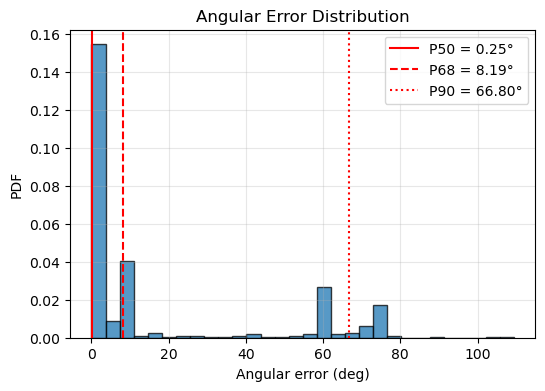

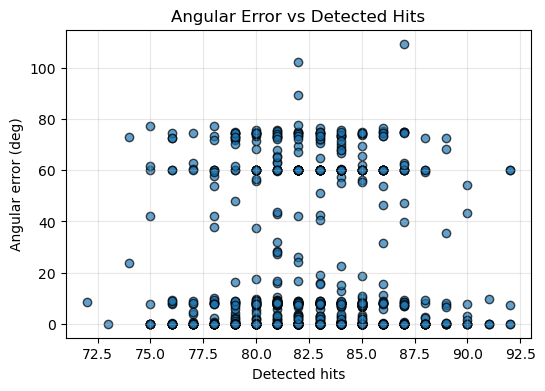

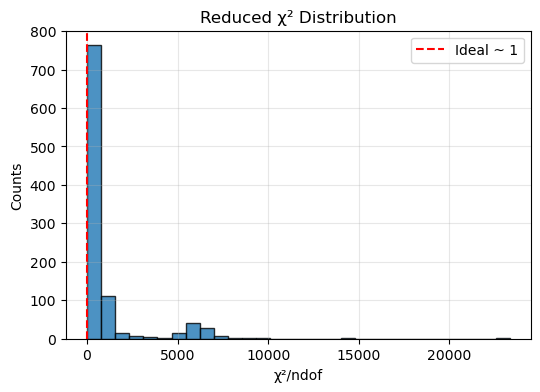

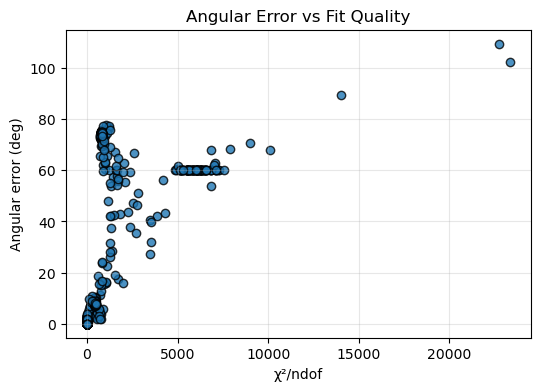

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# ---- helpers ----
def angle_deg(u1, u2):
    u1 = u1 / (np.linalg.norm(u1) + 1e-12)
    u2 = u2 / (np.linalg.norm(u2) + 1e-12)
    cosang = float(np.clip(np.dot(u1, u2), -1.0, 1.0))
    return np.degrees(np.arccos(cosang))

# ---- unpack arrays from `results` ----
u_true   = u  # from your sim
u_hats   = np.array([r["u_hat"] for r in results])
ang_err  = np.array([angle_deg(u_true, ui) for ui in u_hats])
chi2_red = np.array([r["chi2"] / r["ndof"] for r in results])
n_hits   = np.array([r["detected_hits"] for r in results])
sumK     = np.array([r["sumK"] for r in results])
gain     = np.array([r["a_hat"] for r in results])

# ---- 1) Angular error histogram (your “resolution”) ----
p50, p68, p90 = np.percentile(ang_err, [50, 68, 90])
plt.figure(figsize=(6,4))
plt.hist(ang_err, bins=30, density=True, alpha=0.75, edgecolor='k')
for val, lbl, ls in [(p50,'P50','-'), (p68,'P68','--'), (p90,'P90',':')]:
    plt.axvline(val, color='r', linestyle=ls, label=f'{lbl} = {val:.2f}°')
plt.xlabel('Angular error (deg)'); plt.ylabel('PDF')
plt.title('Angular Error Distribution'); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# # ---- 2) Angular error CDF (68% / 90% containment at a glance) ----
# plt.figure(figsize=(6,4))
# xs = np.sort(ang_err); cdf = np.arange(1, len(xs)+1)/len(xs)
# plt.plot(xs, cdf, lw=2)
# plt.axhline(0.68, color='r', ls='--'); plt.axhline(0.90, color='r', ls=':')
# plt.xlabel('Angular error (deg)'); plt.ylabel('CDF')
# plt.title('Angular Error CDF'); plt.grid(alpha=0.3)
# plt.show()

# ---- 3) Error vs detected hits (does more light help?) ----
plt.figure(figsize=(6,4))
plt.scatter(n_hits, ang_err, alpha=0.7, edgecolor='k')
plt.xlabel('Detected hits'); plt.ylabel('Angular error (deg)')
plt.title('Angular Error vs Detected Hits'); plt.grid(alpha=0.3)
plt.show()

# # ---- 4) Error vs total counts (ΣK), colored by χ²/ndof ----
# plt.figure(figsize=(6,4))
# sc = plt.scatter(sumK, ang_err, c=chi2_red, cmap='viridis', alpha=0.85, edgecolor='k')
# plt.xlabel('Total counts ΣK'); plt.ylabel('Angular error (deg)')
# plt.title('Angular Error vs ΣK (color = χ²/ndof)')
# cbar = plt.colorbar(sc); cbar.set_label('χ²/ndof')
# plt.grid(alpha=0.3); plt.show()

# ---- 5) Reduced χ² distribution (fit quality) ----
plt.figure(figsize=(6,4))
plt.hist(chi2_red, bins=30, alpha=0.8, edgecolor='k')
plt.axvline(1.0, color='r', ls='--', label='Ideal ~ 1')
plt.xlabel('χ²/ndof'); plt.ylabel('Counts')
plt.title('Reduced χ² Distribution'); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# ---- 6) Angular error vs χ²/ndof (flag outliers) ----
plt.figure(figsize=(6,4))
plt.scatter(chi2_red, ang_err, alpha=0.8, edgecolor='k')
plt.xlabel('χ²/ndof'); plt.ylabel('Angular error (deg)')
plt.title('Angular Error vs Fit Quality'); plt.grid(alpha=0.3)
plt.show()
